# Dependencies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

from datacollect import *

# Config

In [2]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10
cm = 1 / 2.54

# Input parameters

In [3]:
# Dataset
year = 2018

# Input Dir (Simulation)
path_dataset = f'/Users/kristianboerger/working_files/ledsa/simulation/{year}'
# Input Dir (MIREX)
path_mirex = '/Users/kristianboerger/working_files/ledsa/MIREX'

# Experimental Data, V010 and V011 with Tuloul
simulation_list = ['V001', 'V002', 'V003', 'V004', 'V005', 'V007', ]
mirex_list = ['V001', 'V002', 'V003', 'V004', 'V005', 'V007']

# Timeshift between beginn of recording and ignition
simulation_shift_dict = {'V001':-60, 'V002': -18, 'V003':-20, 'V004': -19, 'V005':-22, 'V006': -20, 'V007':-21, 'V008': -92, 'V009':-65, 'V010': -51, 'V011':-29}
mirex_shift_dict = {'V001':-20, 'V002': -18, 'V003':-20, 'V004': -19, 'V005':-22, 'V006': -20, 'V007':-21, 'V008': -92, 'V009':-65, 'V010': -51, 'V011':-29}

cam_list = ['Cam_01', 'Cam_02']

# Get data

## MIREX + Massloss data

In [4]:
window_mirex = 5 # Average window

mirex_df = pd.DataFrame()
massloss_df = pd.DataFrame()
mass_total_df = pd.DataFrame()
# MIREX data is read from MIREX.dat files and summarized in dataframe.
# Headers are V00X_1, V00X_2, V00X_3, V00X_mlr (mass loss rate), V00X_tm (total mass)
# Standard deviation and mean values are calculated and saved with suffixes 'mean and 'std'
for experiment in mirex_list:
    mirex_file = os.path.join(path_mirex, f'{year}_{experiment}.dat')
    mirex_data = MirexData(mirex_file)
    mirex_data.smooth_data(window=window_mirex)
    mirex_data.set_timeshift(mirex_shift_dict[experiment])
    mirex_df[f"{experiment}_1"] = mirex_data.mirex_1.dropna()
    mirex_df[f"{experiment}_2"] = mirex_data.mirex_2.dropna()
    mirex_df[f"{experiment}_3"] = mirex_data.mirex_3.dropna()
    mirex_df[f"{experiment}_mlr"] = mirex_data.mass_loss_rate.dropna()
    mirex_df[f"{experiment}_tm"] = mirex_data.total_mass.dropna()
mirex_df.drop(["V002_mlr"], axis=1, inplace=True) # Delete because of missing data distorting mean ans std.
mirex_df.drop(["V007_mlr"], axis=1, inplace=True) # Delete because of missing data distorting mean ans std.
mirex_df.drop(["V002_tm"], axis=1, inplace=True) # Delete because of missing data distorting mean ans std.
mirex_df.drop(["V007_tm"], axis=1, inplace=True) # Delete because of missing data distorting mean ans std.
for i in range (0,4):
    mirex_df[f'mean_mirex_{i}'] = mirex_df.filter(regex=f"_{i}").mean(axis=1)
    mirex_df[f'std_mirex_{i}'] = mirex_df.filter(regex=f"_{i}").std(axis=1)
mirex_df[f'mean_mlr'] = mirex_df.filter(regex=f"_mlr").mean(axis=1)
mirex_df[f'std_mlr'] = mirex_df.filter(regex=f"_mlr").std(axis=1)
mirex_df[f'mean_tm'] = mirex_df.filter(regex=f"_tm").mean(axis=1)
mirex_df[f'std_tm'] = mirex_df.filter(regex=f"_tm").std(axis=1)

## Simulation Data

In [5]:
line_list = [0,1,2,3,4,5,6]
channel_list = [0,1,2]
height_list = [3.3,2.3,1.52]

window_sim = 5 # Average window
sim_df = pd.DataFrame()
record_list = []

# Simulation data is read from simulationpaths for cameras in 'cam_list'
# Data is recorded for layers resulting from 'height_list'
# Standard deviation and mean values are calculated and saved with suffixes 'mean and 'std'
for simulation in simulation_list:
    for cam in cam_list:
        path_simulation = os.path.join(path_dataset, simulation, cam)
        sim_data = SimData(path_simulation)
        sim_data.set_timeshift(simulation_shift_dict[simulation])
        for channel in channel_list:
            for line in line_list:
                # for layer in range (0,20): # records data for all layers (takes a while)
                for height in height_list:
                    layer = get_layer_from_height(1, 3.35, height, 20)
                    record = f"{simulation}_{cam}_ch_{channel}_line_{line}_layer_{layer}"
                    extco_raw = sim_data.get_extco_at_layer(channel,layer, 1)[line]
                    extco_raw.name = f"{record}_raw"
                    extco_ma = sim_data.get_extco_at_layer(channel,layer, window_sim)[line]
                    extco_ma.name = f"{record}_ma"
                    record_list.extend([extco_raw, extco_ma])
    print(simulation)

all_records = pd.concat(record_list, axis=1)
all_records = all_records.interpolate(method='nearest')
for simulation in simulation_list:
    for cam in cam_list:
        for channel in channel_list:
            for line in line_list:
                for height in height_list:
                # for layer in range (0,20): # records data for all layers (takes a while)
                    layer = get_layer_from_height(1, 3.35, height, 20)
                    record = f"{cam}_ch_{channel}_line_{line}_layer_{layer}"
                    all_records[f'{record}_mean'] = all_records.filter(regex=f"{record}").mean(axis=1)
                    all_records[f'{record}_std'] = all_records.filter(regex=f"{record}_ma").std(axis=1)

V001
V002
V003
V004
V005
V007


# Control data

## MIREX

Text(0, 0.5, 'extinction coefficient [-]')

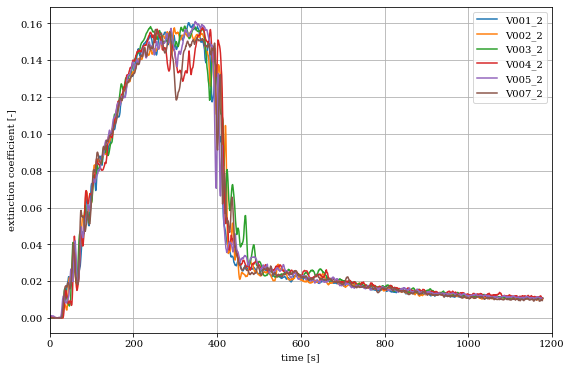

In [6]:
mirex_id = 2 # ID of MIREX, 1 - 3

fig, ax = plt.subplots(figsize=(9, 6))
for record in mirex_df.filter(regex=f"V.*_{mirex_id}"):
    ax.plot(mirex_df[record], label=record)

ax.legend(loc='best')
ax.grid(True)
ax.set_xlim(0,1200)
ax.set_xlabel("time [s]")
ax.set_ylabel("extinction coefficient [-]")

## Simulation data

Text(0, 0.5, 'extinction coefficient [-]')

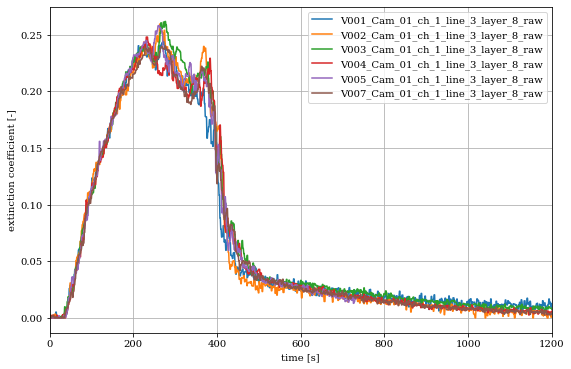

In [7]:
channel = 1 # Camera channel to analyse
line = 3 # LED line
layer = 8 # Height to analyse
cam = 1 # Cam to analyse

fig, ax = plt.subplots(figsize=(9, 6))
for record in all_records.filter(regex=f"Cam_0{cam}_ch_{channel}_line_{line}_layer_{layer}_raw"):
    ax.plot(all_records[record], label=record)
ax.legend(loc='best')
ax.grid(True)
ax.set_xlim(0,1200)
ax.set_xlabel("time [s]")
ax.set_ylabel("extinction coefficient [-]")

# Plot data

## HRR + Mass loss (mean values + standard deviation)

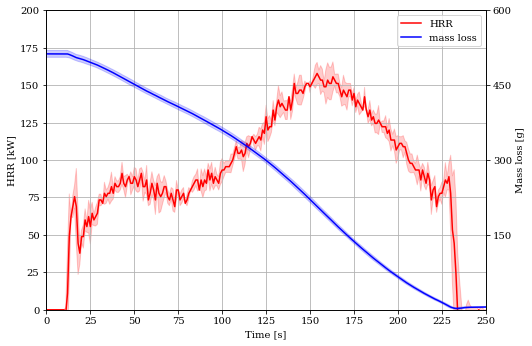

In [8]:
# General parameters
hoc = 44440 # heat of combustion
tara = -20 # Tare weight

# Plot Parameters
fig_width = 20 #cm

fig, ax1 = plt.subplots()
fig.set_size_inches(fig_width * cm, 0.7 * fig_width * cm)

pl1 = ax1.plot(mirex_df.index-5,-mirex_df['mean_mlr']*hoc, label="HRR", color='red')
ax1.fill_between(mirex_df.index-5, -(mirex_df['mean_mlr'] - mirex_df['std_mlr'])*hoc, -(mirex_df['mean_mlr'] + mirex_df['std_mlr'])*44440, alpha=0.2, color='red')

ax2 = ax1.twinx()
pl2 = ax2.plot(mirex_df.index-5,mirex_df['mean_tm']*1000+tara, label="mass loss", color='blue')
ax2.fill_between(mirex_df.index-5, (mirex_df['mean_tm'] - mirex_df['std_tm'])*1000+tara, (mirex_df['mean_tm'] + mirex_df['std_tm'])*1000+tara, alpha=0.2, color='blue')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('HRR [kW]')
ax2.set_ylabel('Mass loss [g]')

ax1.set_xlim(0, 250)
ax1.set_ylim(0,200)
ax2.set_ylim(0,600)
ax1.locator_params(axis="x", nbins=10)
ax1.locator_params(axis="y", nbins=8)
ax2.set_yticks([150, 300, 450, 600])
ax1.grid(True)

plots = pl1 + pl2
labels = [l.get_label() for l in plots]
ax2.legend(plots, labels, loc='best')

## Extinction coefficient (mean values + standard deviation)

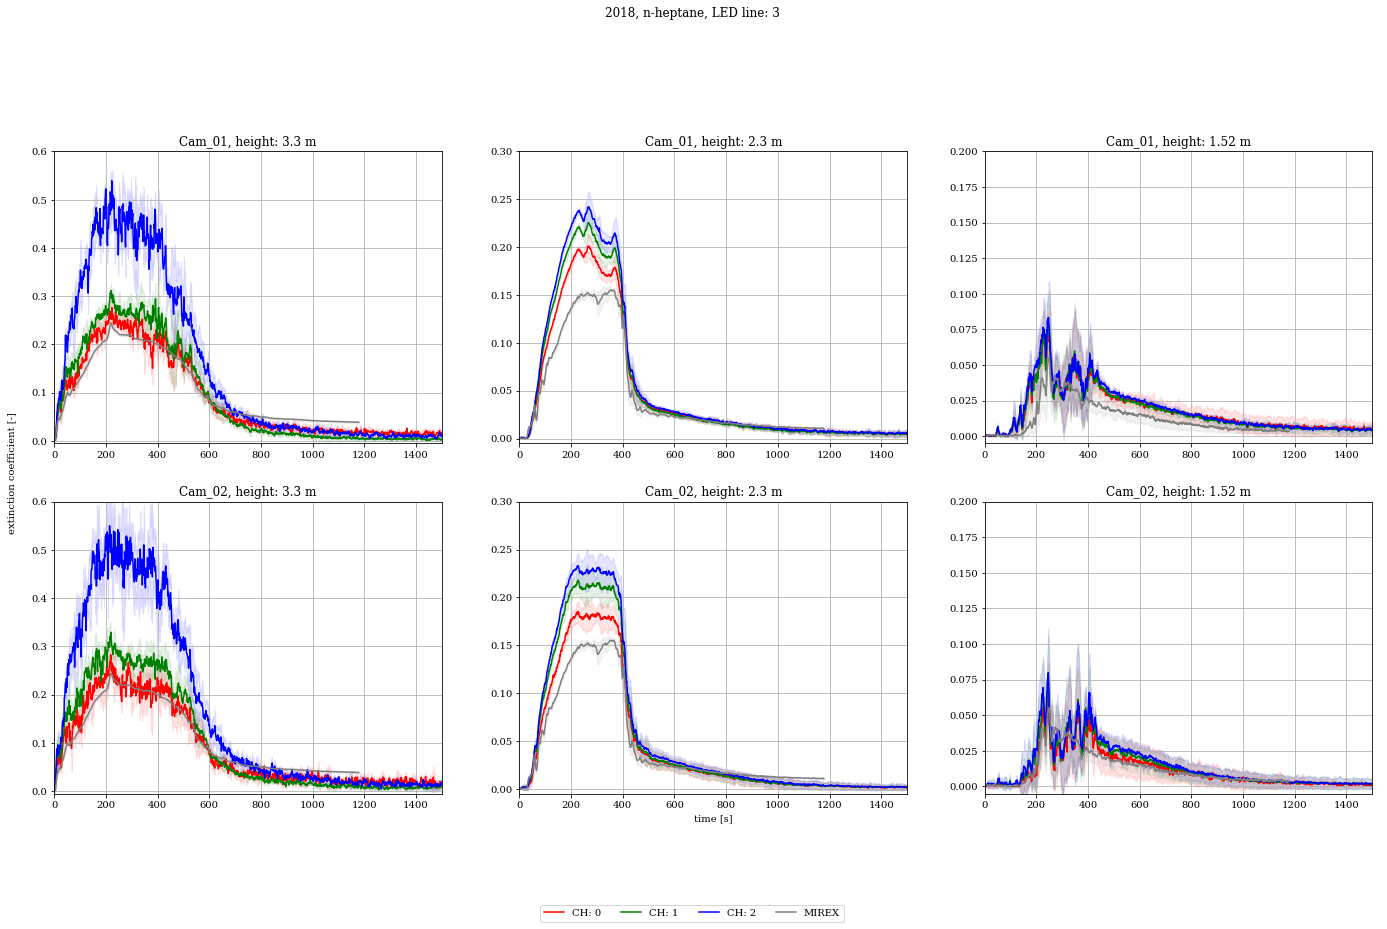

In [9]:
# General parameters
line = 3 # LED line
channel_list = [0,1,2] # Camera channels to analyse
height_list = [3.3,2.3,1.52]
cam_list = ['Cam_01', 'Cam_02'] # Cameras to analyse
mirex_id_list = [1,2,3] # MIREX to analyse
n_rows = len(height_list)
n_cols = len(cam_list)

# Plot Parameters
fig_width = 60 #cm
color_list = ['red', 'green', 'blue'] # Coloring graphs of camera channels
min_time = 0 # Minimum datapoint
max_time = 1500 # Maximum datapoint
y_lim_list = [0.6,0.3,0.2] # Y limits for plots at different heights
convert_grid = True

fig = plt.figure()
if convert_grid == True:
    gird = gridspec.GridSpec(ncols=n_rows, nrows=n_cols, figure=fig)
    fig.set_size_inches(fig_width * cm,  n_cols/2 * 1.5/n_rows * fig_width * cm)

else:
    gird = gridspec.GridSpec(ncols=n_cols, nrows=n_rows, figure=fig)
    fig.set_size_inches(fig_width * cm,  n_rows / 1.5 * 1 / n_cols * fig_width * cm)

for i, (height, mirex, y_lim) in enumerate(zip(height_list, mirex_id_list, y_lim_list)):
    for j, cam in enumerate(cam_list):
        if convert_grid == True:
            ax = fig.add_subplot(gird[j, i])
        else:
            ax = fig.add_subplot(gird[i, j])

        for channel, color in zip(channel_list, color_list):
            layer = get_layer_from_height(1, 3.35, height, 20)
            record_sim = f"{cam}_ch_{channel}_line_{line}_layer_{layer}"
            mean_sim = all_records[f'{record_sim}_mean']
            std_sim = all_records[f'{record_sim}_std']
            ax.fill_between(all_records.index, mean_sim - std_sim, mean_sim + std_sim, alpha=0.1, color=color)
            label = f"CH: {channel}" if i == 0 and j == 0 else "__no_label__"
            ax.plot(mean_sim, color=color, label=label)
        ax.set_xlim(min_time, max_time)
        ax.set_ylim(-0.005, y_lim)
        ax.grid(True)
        record_mirex = f'mirex_{mirex}'
        mean_mirex = mirex_df[f"mean_{record_mirex}"]
        std_mirex = mirex_df[f"std_{record_mirex}"]
        label = f"MIREX" if i == 0 and j == 0 else "__no_label__"
        ax.plot(mean_mirex, color='gray', label=label)
        ax.fill_between(mirex_df.index, mean_mirex - std_mirex, mean_mirex + std_mirex, alpha=0.1, color='gray')
        ax.set_title(f"{cam}, height: {height} m")

fig.add_subplot(111, frameon=False)
fig.suptitle(f"{year}, n-heptane, LED line: {line}",y=1.05)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("time [s]")
plt.ylabel("extinction coefficient [-]",labelpad=15)
fig.legend(bbox_to_anchor=(0.5, 0.0), loc='upper center', ncol=4)
# plt.tight_layout()
